In [1]:
import io, pyproj, shapely.geometry
import numpy as np
from PIL import Image, ImageDraw
from math import pi, log, tan, exp, atan, log2, log10, floor
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.collections import PatchCollection
# import pygeos
# You will need django < 2.3
from django.contrib.gis.geos import Point, Polygon, MultiPolygon

In [2]:
class settings:
    PROPERTY_OUTLINE_COLOR = (1,0,1,1)
    PROPERTY_OUTLINE_WIDTH = 3

In [3]:
def render_vectors(geoms,
                   bbox,
                   pixel_height,
                   pixel_width,
                   dpi=300,
                   patch_kwargs={},
                   labels=None,
                   label_kwargs={}):
    """
    Renders the geometries of a vector layer as an image with a transparent
    background.

    Parameters
    ----------
    geoms : list-like of Polygon or MultiPolygon objects
      the geometries that will be plotted
    bbox : list-like of numerics
      the xmin, ymin, xmax, and ymax coordinates describing the bounding box
      for the image
    pixel_height : int
      the desired height of the image, in pixels
    pixel_width : int
      the desired width of the image, in pixels
    dpi : int, optional
      dots per inch for the rendered image, default is 350
    patch_kwargs : dict, optional
      keyword arguments to pass to matplotlib.PatchCollection
    labels : list-like of strings, optional
      labels used to annotate polygons
    label_kwargs : dict, optional
      keyword arguments to pass to ax.annotate

    Returns
    -------
    img : PIL image
      the vector rendered as an image
    """
    img_width, img_height = pixel_width / float(dpi), pixel_height / float(dpi)
    xmin, ymin, xmax, ymax = bbox

    fig, ax = plt.subplots(figsize=(img_width, img_height), dpi=dpi)
    ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    ax.axis('off')

    polys = []
    
    print("NUM GEOMS: %d" % len(geoms)) 

    for geom in geoms:
        if type(geom) == Polygon:
            shape = shapely.geometry.Polygon(geom.coords)
            patch = patches.Polygon(np.array(shape.exterior.xy).T)
            polys.append(patch)
        elif type(geom) == MultiPolygon:
            for poly_coords in geom.coords[0]:
                poly = shapely.geometry.Polygon(poly_coords)
                patch = patches.Polygon(np.array(poly.exterior.xy).T)
                polys.append(patch)
                
    print("NUM POLYS: %d" % len(polys))            
    
    ax.add_collection(PatchCollection(polys, **patch_kwargs))

    if labels is not None:
        for i, label in enumerate(labels):
            ax.annotate(text=label,
                        xy=geoms[i].centroid.coords[0],
                        **label_kwargs)

    img = plt_to_pil_image(fig, dpi=dpi)
    print("Image With White Background:")
    display(img)
    img.show()
    print("--------------------------------------------------------")
    
    img = plt_to_pil_image(fig, dpi=dpi, transparent=(255,255,255))
    print("image With Transparent Background:")
    display(img)
    print("--------------------------------------------------------")
    
    return img


def get_property_image_layer(property, property_specs):
    """
    Produce an image of the taxlots belonging to a property.

    Parameters
    ----------
    property : a property object
      a property record from the DB
    property_specs : dict
      pre-computed aspects of the property, including: bbox, width, and height

    Returns
    -------
    taxlot_img : dict
      dictionary with 'image' and 'attribution' as keys
    """
    bbox = [float(x) for x in property_specs['bbox'].split(',')]
    pixel_width = property_specs['width']
    pixel_height = property_specs['height']
    edgecolor = settings.PROPERTY_OUTLINE_COLOR
    linewidth = settings.PROPERTY_OUTLINE_WIDTH
    patch_kwargs = dict(fc='none', ec=edgecolor, lw=linewidth)

    img = render_vectors(geoms=[property.geometry_orig],
                         bbox=bbox,
                         pixel_width=pixel_width,
                         pixel_height=pixel_height,
                         patch_kwargs=patch_kwargs
                         )
    
    taxlot_img = {'image': img, 'attribution': None}

    return taxlot_img

def plt_to_pil_image(plt_figure, dpi=200, transparent=None):
    """
    Converts a matplotlib figure to a PIL Image (in memory).

    Parameters
    ---------
    plt_figure : matplotlib Figure object
      the figure to convert
    dpi : int
      the number of dots per inch to render the image
    transparent : Tuple, optional
      If set, an RGB tuple (0-255 values) to define the transparency color
      This tuple may be 3 values (for RGB, assuming full transparency) or
      4 values: providing an "alpha" value for transparency.

    Returns
    -------
    pil_image : Image
      the figure converted to a PIL Image
    """
    fig = plt.figure(plt_figure.number)
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=dpi)
    buf.seek(0)
    pil_image = Image.open(buf)
    plt.close()
    if transparent and len(transparent) >= 3:
        if len(transparent) >= 4:
            alpha = transparent[3]
        else:
            alpha = 0
        pil_image = pil_image.convert("RGBA")
        img_data = pil_image.getdata()
        new_data = []
        for datum in img_data:
            if datum[0] == transparent[0] and datum[1] == transparent[1] and datum[2] == transparent[2]:
                new_data.append((datum[0],datum[1],datum[2],alpha))
            else:
                new_data.append((datum[0],datum[1],datum[2],255))
        pil_image.putdata(new_data)

    return pil_image

NUM GEOMS: 1
NUM POLYS: 1
Image With White Background:


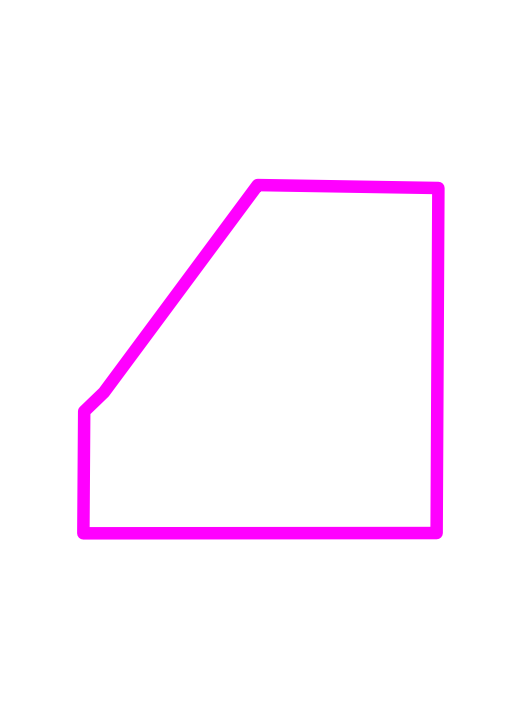

--------------------------------------------------------
image With Transparent Background:


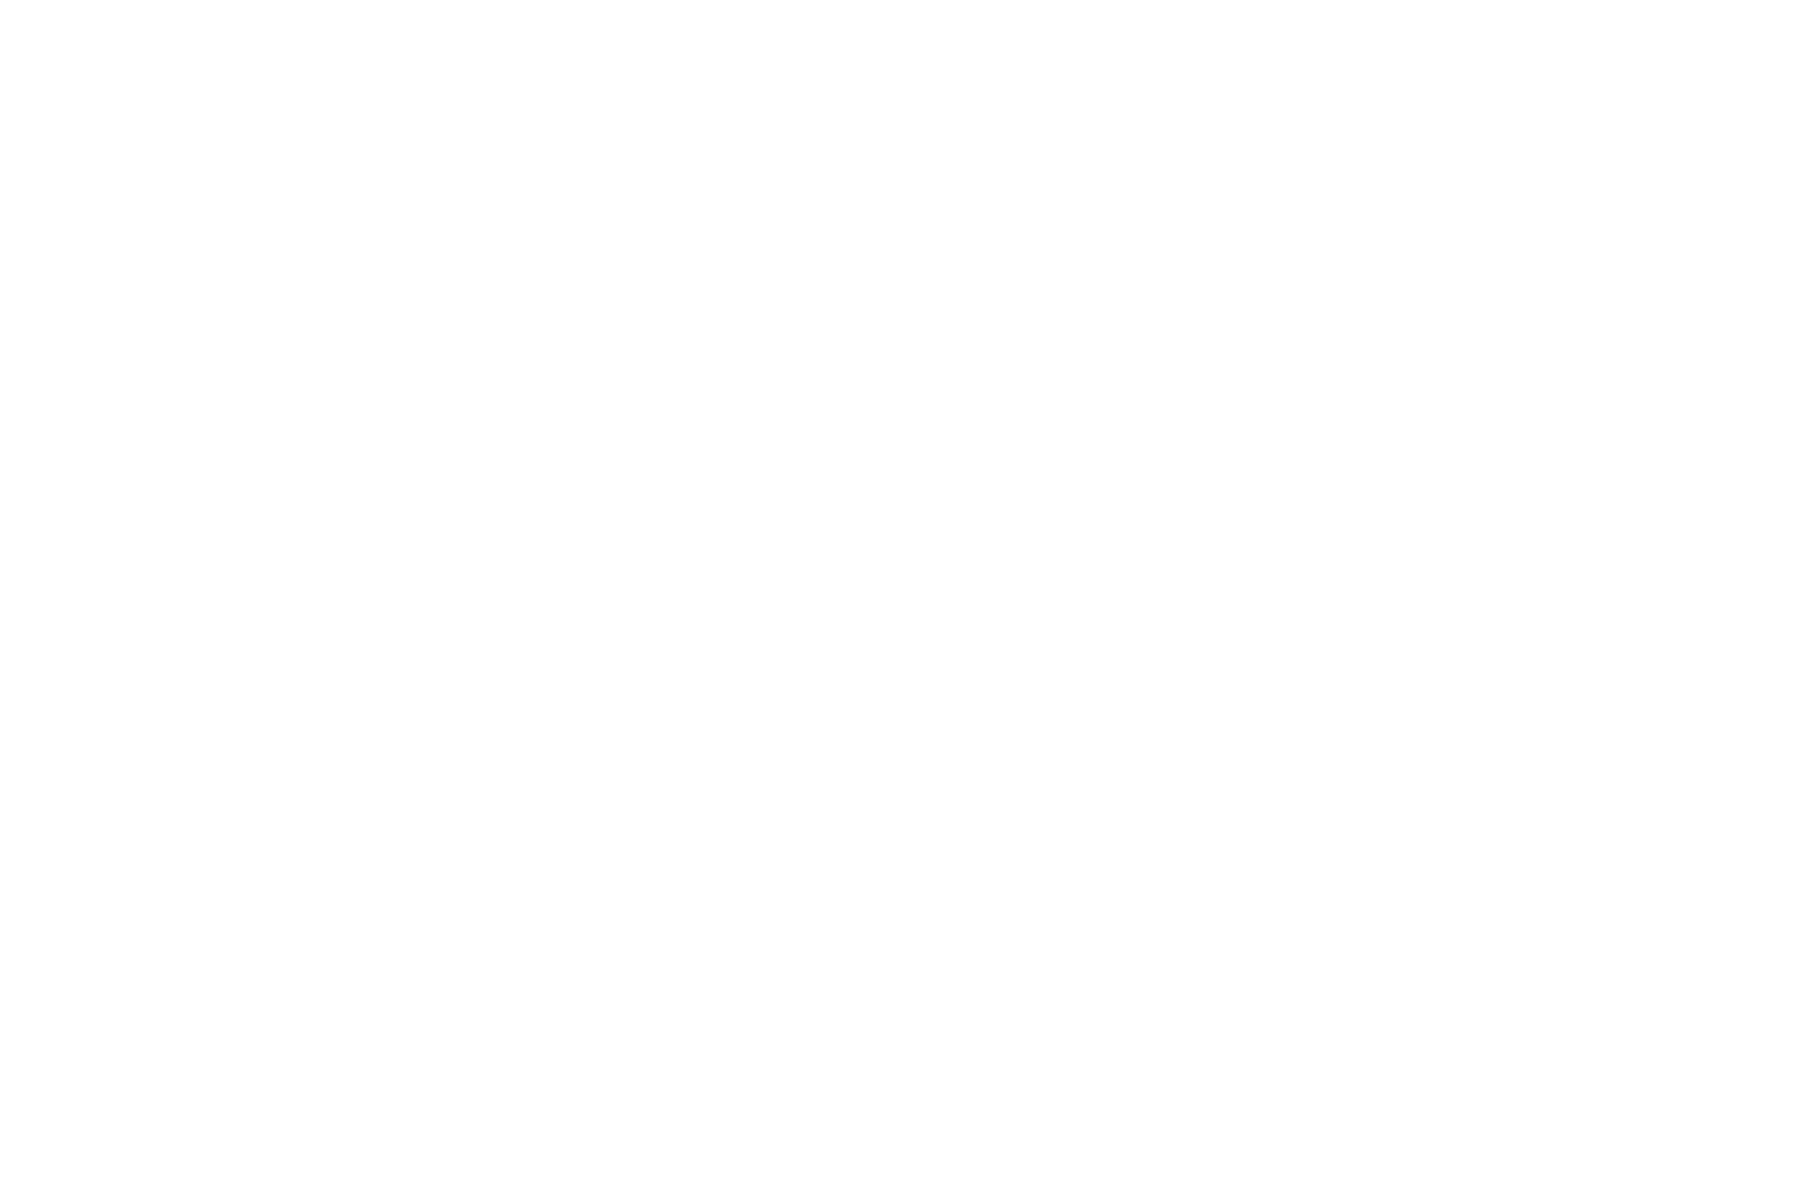

--------------------------------------------------------
Width: 1800, Height: 1200


In [4]:
# Values below come from the pygeos docs: 
#   https://pygeos.readthedocs.io/en/latest/geometry.html#pygeos.geometry.get_type_id
# Polygon = 3
# MultiPolygon = 6
# pygeos.Geometry('MULTIPOLYGON (((-13798702.82100015 5750670.155100086, -13798638.20350014 5750734.011600086, -13798218.85050015 5751314.490800085, -13798133.86170015 5751432.128000085, -13798119.40630015 5751431.886000084, -13797541.24830015 5751422.188500086, -13797546.99840014 5750260.630900089, -13798126.40530014 5750260.168400083, -13798705.61780015 5750259.668800077, -13798702.82100015 5750670.155100086)))')


# geoPolygon = Polygon(((-13798702.82100015 5750670.155100086, -13798638.20350014 5750734.011600086, -13798218.85050015 5751314.490800085, -13798133.86170015 5751432.128000085, -13798119.40630015 5751431.886000084, -13797541.24830015 5751422.188500086, -13797546.99840014 5750260.630900089, -13798126.40530014 5750260.168400083, -13798705.61780015 5750259.668800077, -13798702.82100015 5750670.155100086)))
geoPolygon = Polygon(((-13798702.821000148, 5750670.155100086), (-13798638.203500144, 5750734.011600086), (-13798218.850500146, 5751314.4908000855), (-13798133.861700147, 5751432.128000085), (-13798119.406300148, 5751431.886000084), (-13797541.24830015, 5751422.188500086), (-13797546.998400144, 5750260.630900089), (-13798126.405300144, 5750260.168400083), (-13798705.61780015, 5750259.668800077), (-13798702.821000148, 5750670.155100086)),)
geoMultiPolygon = MultiPolygon([geoPolygon,])
# geoMultiPolygon = MultiPolygon(,)

class property:
    geometry_orig = geoMultiPolygon
    
#     def __type__(self):
#         return pygeos.geometry.get_type_id(self.geometry_orig)
    
property_specs = {
    'orientation': 'landscape', 
    'width': 509, 
    'height': 722, 
    'bbox': '-13798770.304994594,5749928.331516213,-13797476.561105706,5751763.46528395', 
    'zoom': {
        'lat': 45.81640625, 
        'lon': -123.951171875, 
        'zoom': 14.717887878417969
    }
}

result_dict = get_property_image_layer(property, property_specs)
print("Width: %s, Height: %s" % (result_dict['image'].width, result_dict['image'].height))
# display(result_dict['image'])